In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(train_data, test_data), info = tfds.load('food101',
                                          as_supervised=True,
                                          split=['train', 'validation'],
                                          shuffle_files=True,
                                          with_info=True,
                                          )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteHIAHZF/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteHIAHZF/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
class_names = info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [4]:
IMG_SIZE = 224

def preprocess_image(image, label):
    img = tf.cast(image, tf.float32)  # Convert image to float32
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize the image
    # img = img / 255.0  # Normalize the image
    return img, label

In [5]:
def get_class_index(class_name):
  """
  Getting the index of the class name entered.
  """
  return class_names.index(class_name)

In [ ]:
pizza_steak_train = train_data.filter(lambda image, label: label == get_class_index('pizza') or label == get_class_index('steak')).map(preprocess_image)
pizza_steak_train = pizza_steak_train.map(lambda image, label: (image, tf.where(tf.equal(label, 76), 0, 1))).repeat().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

pizza_steak_test = test_data.filter(lambda image, label: label == get_class_index('pizza') or label == get_class_index('steak')).map(preprocess_image)
pizza_steak_test = pizza_steak_test.batch(32).map(lambda image, label: (image, tf.where(tf.equal(label, 76), 0, 1))).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def show_random_images(skip_num=0, take_num=1, dataset=pizza_steak_train):
  """
  Showing 12 random samples of the data
  """
  plt.figure(figsize=(15, 10))
  for image, label in dataset.skip(skip_num).take(take_num):
    for i in range(12):
      plt.subplot(3, 4, i+1)
      plt.imshow(image[i].numpy().astype('uint8'))
      plt.title(f'{class_names[label[i]]}')
      plt.axis(False)


In [6]:
def create_early_stopping_callback(monitor='val_accuracy'):
  return tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                  patience=3)

In [13]:
def create_checkpoint_callback(path='checkpoint/checkpoint.ckpt', monitor='val_loss'):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_weights_only=True,  
    save_best_only=True,  
    monitor=monitor,  
    verbose=1)

# Transfer Learning

In [ ]:
# creating the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# set the transfer learning model as a feature extractor
base_model.trainable = False

# Define the inputs layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')

# initialize the base model and connect it to the inputs layer
x = base_model(inputs, training=False)

# To Take the important features from the image
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# the output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x) 

model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

history_6 = model_6.fit(pizza_steak_train,
                    epochs=100,
                    steps_per_epoch=47,
                    validation_data=pizza_steak_test,
                    validation_steps=8,
                    callbacks=[create_early_stopping_callback(monitor='val_accuracy')] 
                    )

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/100
47/47 [==============================] - 123s 2s/step - loss: 0.3840 - accuracy: 0.9096 - val_loss: 0.1848 - val_accuracy: 0.9922
Epoch 2/100
47/47 [==============================] - 103s 2s/step - loss: 0.1883 - accuracy: 0.9694 - val_loss: 0.1137 - val_accuracy: 0.9961
Epoch 3/100
47/47 [==============================] - 105s 2s/step - loss: 0.1426 - accuracy: 0.9707 - val_loss: 0.0856 - val_accuracy: 0.9961
Epoch 4/100
47/47 [==============================] - 101s 2s/step - loss: 0.1205 - accuracy: 0.9714 - val_loss: 0.0715 - val_accuracy: 0.9961
Epoch 5/100
47/47 [==============================] - 106s 2s/step - loss: 0.1076 - accuracy: 0.9727 - val_loss: 0.0624 - val_accuracy: 0.9961


# Working with 20 % precent of the data

In [7]:
train_data = train_data.shuffle(1000).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.shuffle(1000).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_20_percent = train_data.take(int(0.2 * len(train_data)))
test_data_20_percent = test_data.take(int(0.2 * len(test_data)))

In [ ]:
len(train_data), len(test_data), len(train_data_20_percent), len(test_data_20_percent)

(2368, 790, 473, 158)

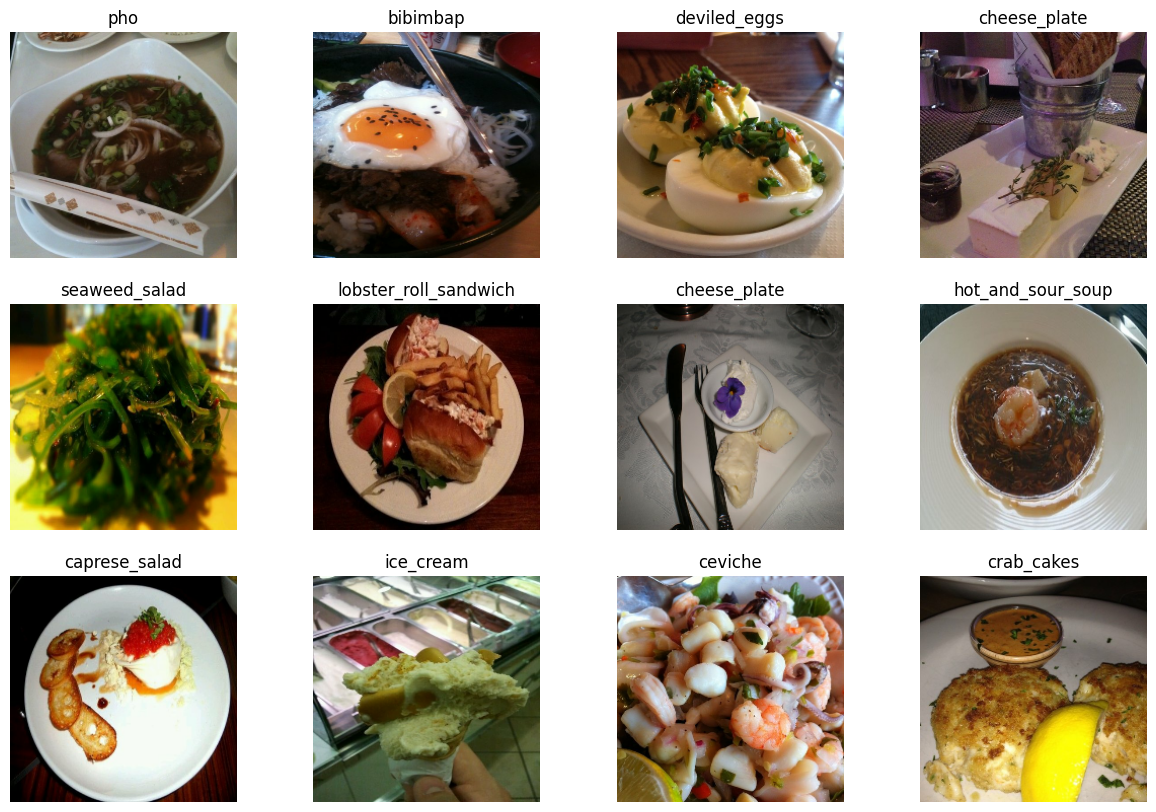

In [ ]:
show_random_images(dataset=train_data_20_percent)

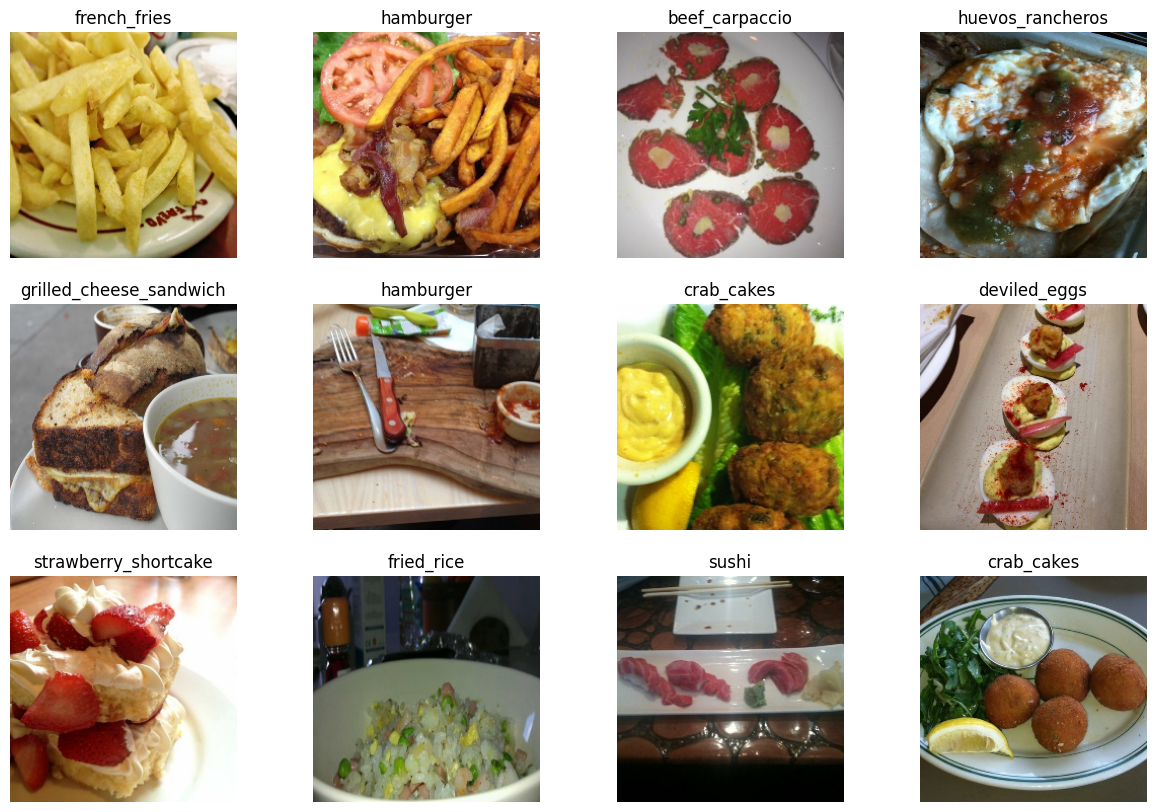

In [ ]:
show_random_images(dataset=train_data_20_percent,skip_num=2, take_num=1)

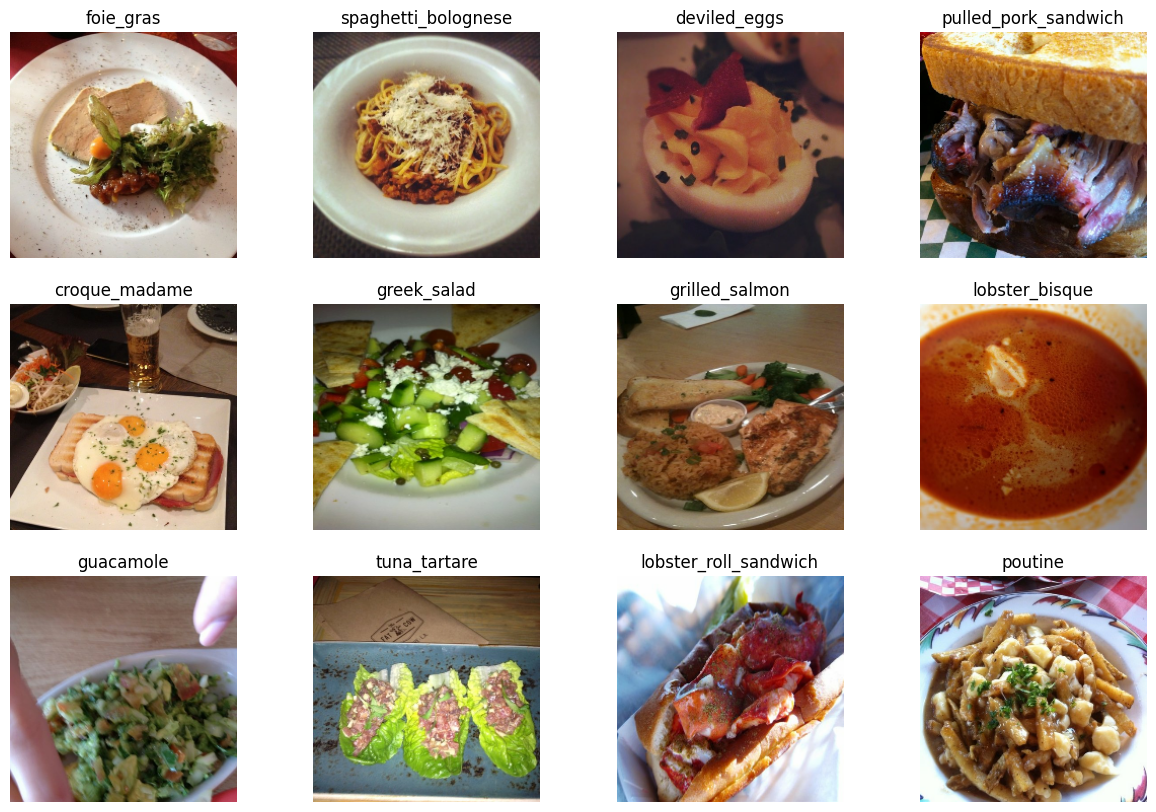

In [ ]:
show_random_images(dataset=test_data_20_percent,skip_num=2, take_num=1)

In [ ]:
len(train_data_20_percent), len(test_data_20_percent)

(473, 158)

In [ ]:
# creating the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# set the transfer learning model as a feature extractor
base_model.trainable = False

# Define the inputs layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')

# initialize the base model and connect it to the inputs layer
x = base_model(inputs, training=False)

# To Take the important features from the image
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# the output layer
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) 

model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_5 = model_5.fit(train_data_20_percent,
                    epochs=100,
                    steps_per_epoch=len(train_data_20_percent),
                    validation_data=test_data_20_percent,
                    validation_steps=len(test_data_20_percent),
                    callbacks=[create_early_stopping_callback()] 
                    )

Epoch 1/100
473/473 [==============================] - 72s 116ms/step - loss: 2.5315 - accuracy: 0.4393 - val_loss: 1.6469 - val_accuracy: 0.5961
Epoch 2/100
473/473 [==============================] - 54s 112ms/step - loss: 1.6379 - accuracy: 0.6004 - val_loss: 1.3699 - val_accuracy: 0.6499
Epoch 3/100
473/473 [==============================] - 56s 116ms/step - loss: 1.3709 - accuracy: 0.6596 - val_loss: 1.2907 - val_accuracy: 0.6586
Epoch 4/100
473/473 [==============================] - 54s 111ms/step - loss: 1.2803 - accuracy: 0.6746 - val_loss: 1.2185 - val_accuracy: 0.6742
Epoch 5/100
473/473 [==============================] - 54s 110ms/step - loss: 1.1391 - accuracy: 0.7120 - val_loss: 1.1922 - val_accuracy: 0.6814
Epoch 6/100
473/473 [==============================] - 55s 114ms/step - loss: 1.1210 - accuracy: 0.7137 - val_loss: 1.1514 - val_accuracy: 0.6913
Epoch 7/100
473/473 [==============================] - 54s 112ms/step - loss: 0.9972 - accuracy: 0.7500 - val_loss: 1.1475 -

# Method for evaluation

In [ ]:
def test_visualize(model_class, dataset=test_data, skip_num=0, take_num=1 ):
  plt.figure(figsize=(15, 10))
  for image_test, label_test in dataset.skip(skip_num).take(take_num):
    for i in range(12):
      plt.subplot(6, 2, i+1)
      first_image = image_test[i].numpy().astype('uint8')
      first_label = label_test[i].numpy()

      actual_value = class_names[first_label]

      prediction = model_class.predict(tf.expand_dims(first_image, axis=0))

      predicted_class = class_names[tf.argmax(prediction[0])]

      if actual_value == predicted_class:
        color = 'green'
      else: 
        color = 'red'
      
      plt.imshow(first_image)
      plt.title(f"Actual: {actual_value}, predicted: {predicted_class}", color=color)
      plt.axis(False);

1/1 [==============================] - 0s 31ms/step


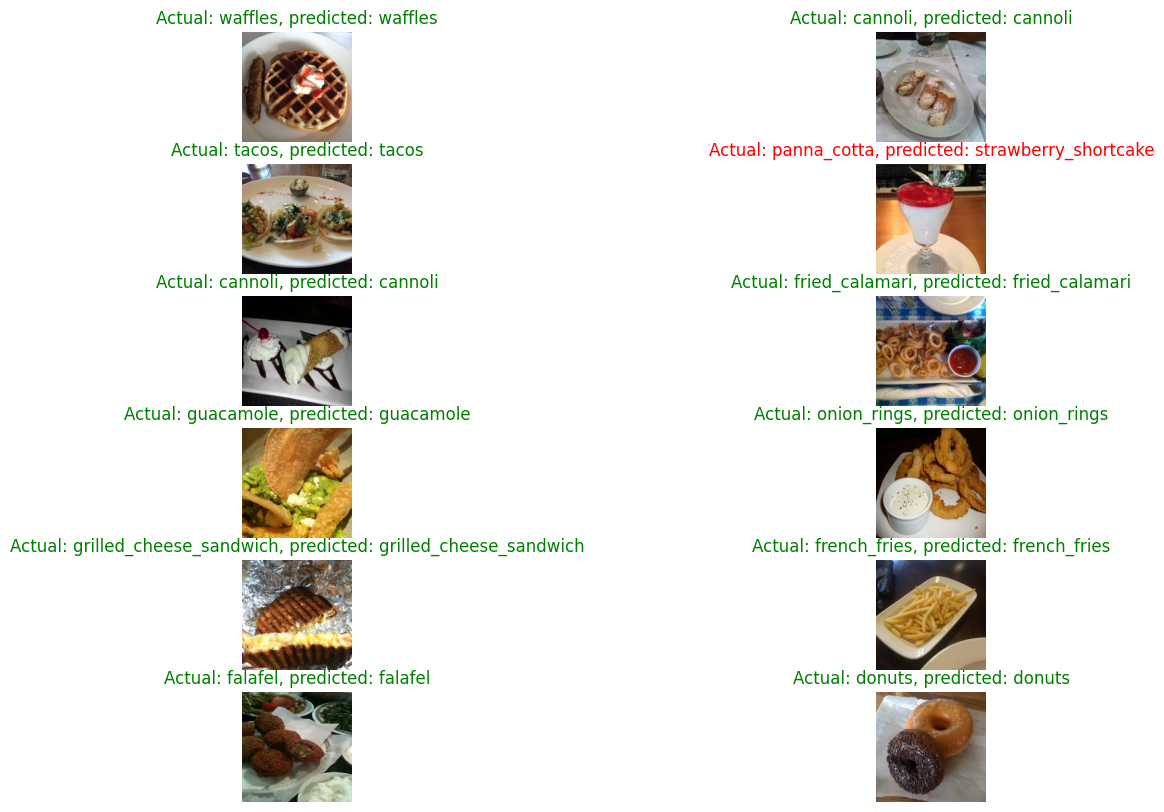

In [ ]:
test_visualize(dataset=test_data_20_percent, model_class=model_5)

1/1 [==============================] - 0s 38ms/step


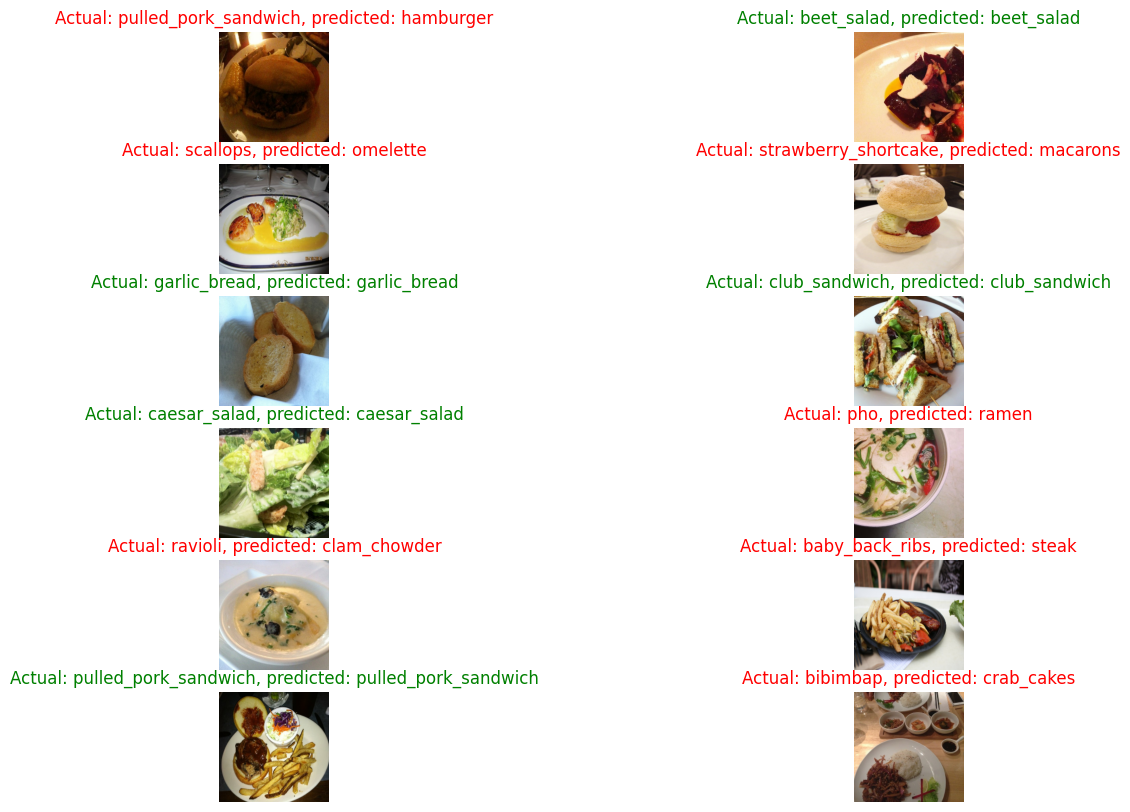

In [ ]:
test_visualize(dataset=test_data_20_percent, model_class=model_5, skip_num=2)

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics 
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='val loss')
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.legend()

  # plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Accuracy')
  plt.plot(epochs, val_accuracy, label='val Accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend()

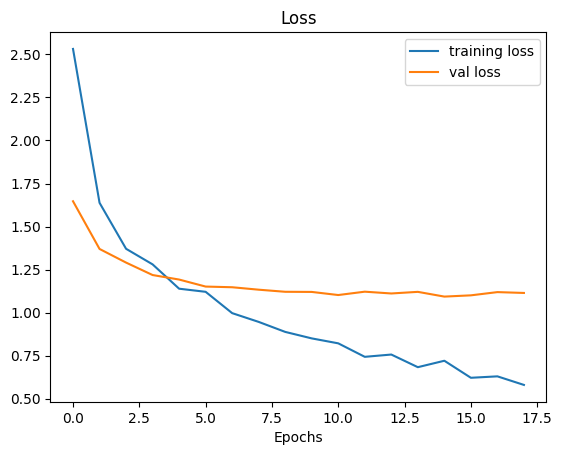

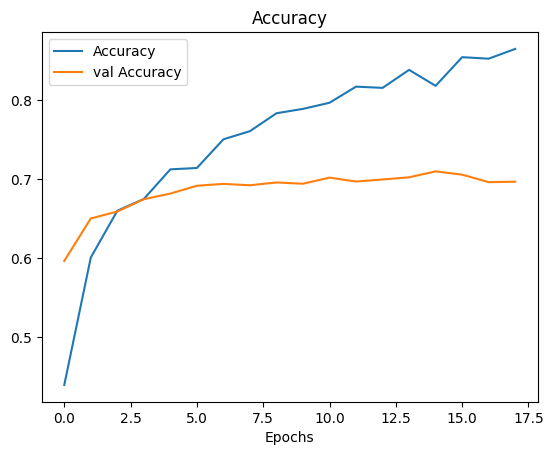

In [ ]:
plot_loss_curves(history_5)

# Trying With 50% of the data

In [ ]:
# train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# train_data = train_data.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# test_data = test_data.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_50_percent = train_data.take(int(0.5 * len(train_data)))
test_data_50_percent = test_data.take(int(0.5 * len(test_data)))

In [ ]:
len(train_data), len(train_data_50_percent), len(test_data_50_percent), len(test_data)

(2368, 1184, 395, 790)

In [ ]:
# creating the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# set the transfer learning model as a feature extractor
base_model.trainable = False

# Define the inputs layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')

# initialize the base model and connect it to the inputs layer
x = base_model(inputs, training=False)

# To Take the important features from the image
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# the output layer
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) 

model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_6 = model_6.fit(train_data_50_percent,
                    epochs=100,
                    steps_per_epoch=len(train_data_50_percent),
                    validation_data=test_data_50_percent,
                    validation_steps=int( 0.2 * len(test_data_50_percent)),
                    callbacks=[create_early_stopping_callback()] 
                    )

Epoch 1/100
1184/1184 [==============================] - 121s 95ms/step - loss: 1.9943 - accuracy: 0.5323 - val_loss: 1.3033 - val_accuracy: 0.6653
Epoch 2/100
1184/1184 [==============================] - 106s 89ms/step - loss: 1.3636 - accuracy: 0.6511 - val_loss: 1.1386 - val_accuracy: 0.6986
Epoch 3/100
1184/1184 [==============================] - 110s 90ms/step - loss: 1.2297 - accuracy: 0.6832 - val_loss: 1.0888 - val_accuracy: 0.7045
Epoch 4/100
1184/1184 [==============================] - 109s 89ms/step - loss: 1.1257 - accuracy: 0.7087 - val_loss: 1.0640 - val_accuracy: 0.7065
Epoch 5/100
1184/1184 [==============================] - 114s 95ms/step - loss: 1.0265 - accuracy: 0.7333 - val_loss: 1.0088 - val_accuracy: 0.7239
Epoch 6/100
1184/1184 [==============================] - 111s 93ms/step - loss: 0.9875 - accuracy: 0.7421 - val_loss: 1.0096 - val_accuracy: 0.7195
Epoch 7/100
1184/1184 [==============================] - 110s 91ms/step - loss: 0.9796 - accuracy: 0.7425 - val_

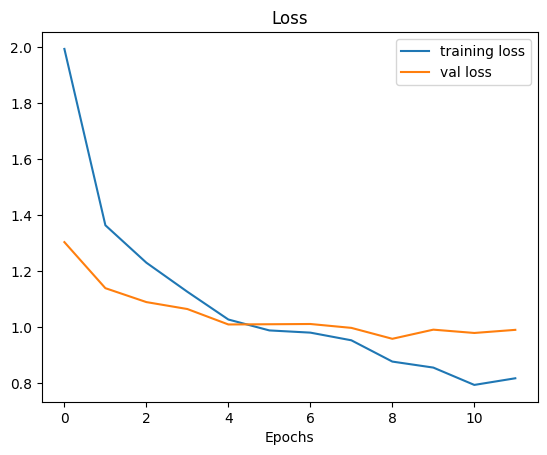

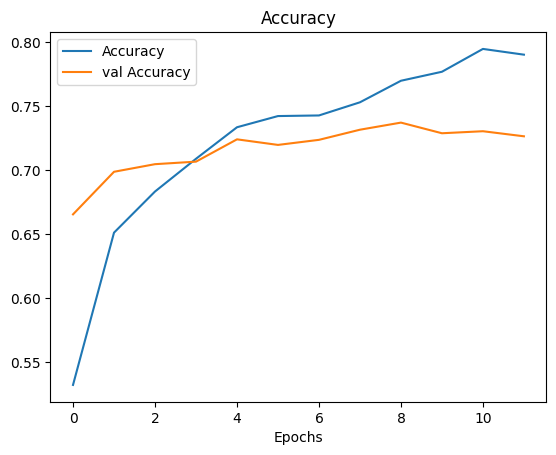

In [ ]:
plot_loss_curves(history_6)

1/1 [==============================] - 0s 25ms/step


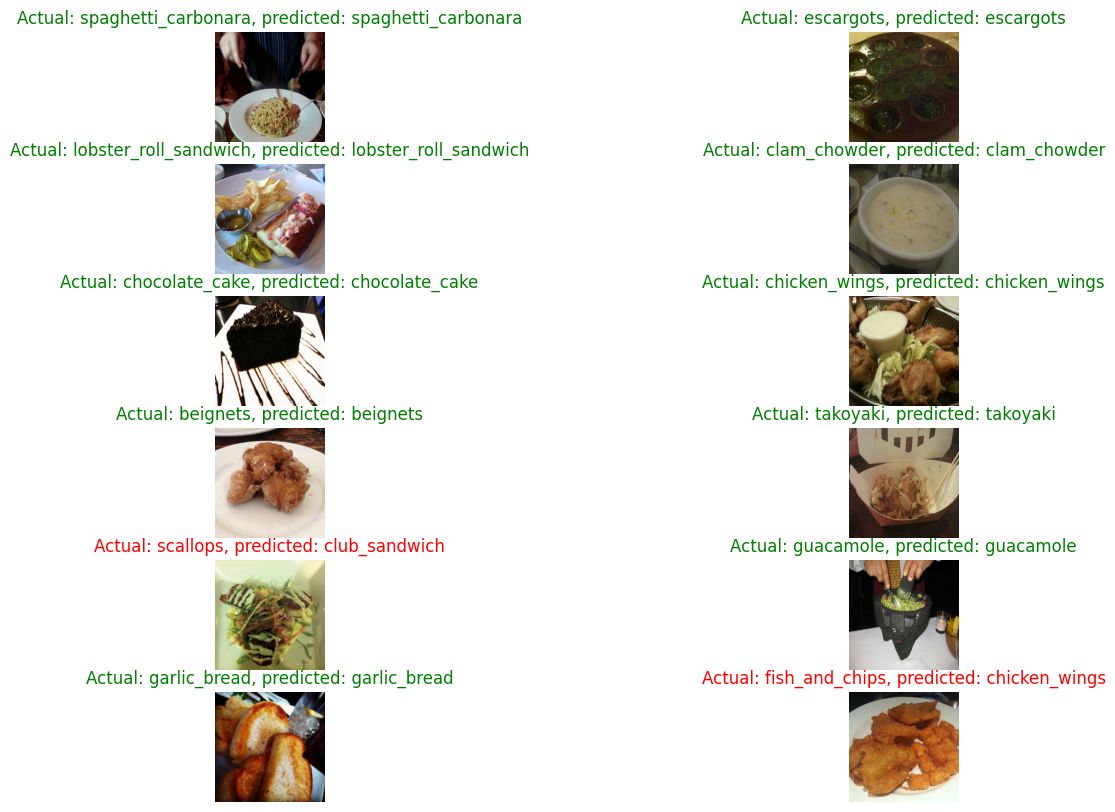

In [ ]:
test_visualize(dataset=train_data_50_percent, model_class=model_6)


1/1 [==============================] - 0s 25ms/step


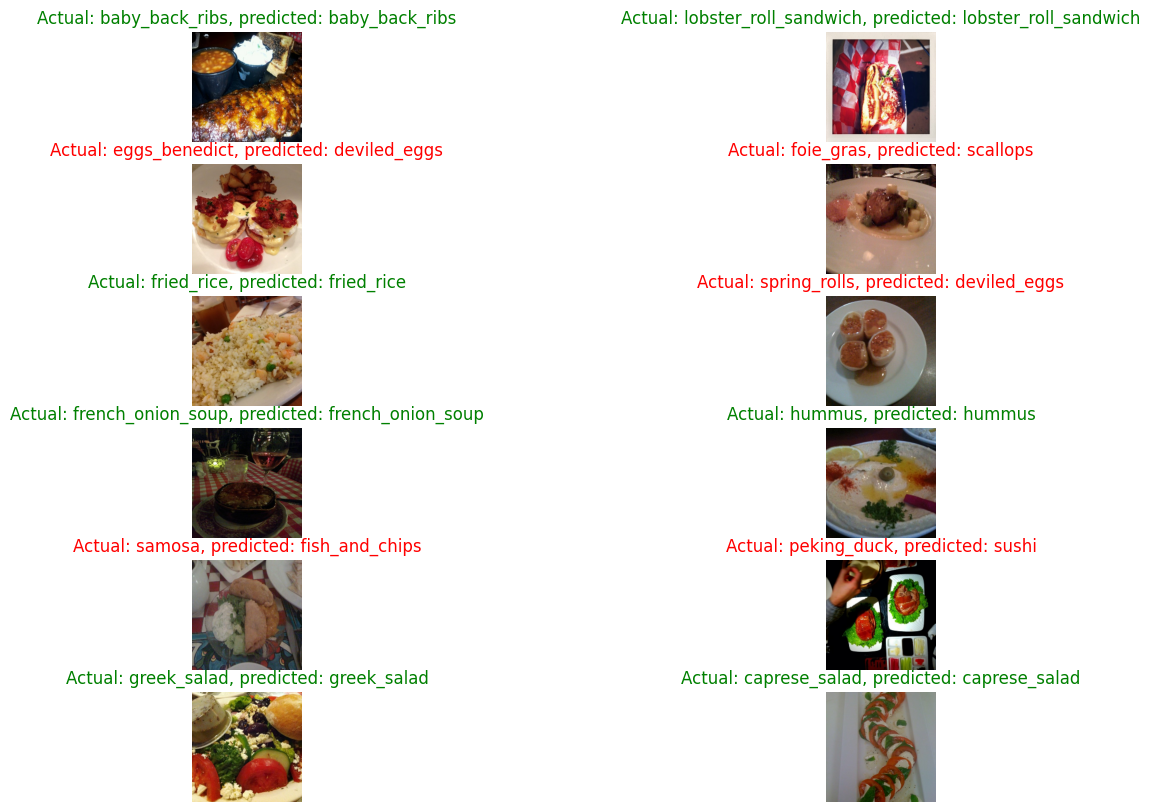

In [ ]:
test_visualize(dataset=train_data_50_percent, model_class=model_6, skip_num=2)


# 50% of data with data augmentation

In [11]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

In [12]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
len(train_data_50_percent), len(test_data_50_percent)

(1184, 395)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

# creating the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# set the transfer learning model as a feature extractor
base_model.trainable = False

# Define the inputs layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')

x = data_augmentation(inputs)

# initialize the base model and connect it to the inputs layer
x = base_model(x, training=False)

# To Take the important features from the image
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# the output layer
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) 

model_7 = tf.keras.Model(inputs, outputs)

model_7.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_7 = model_7.fit(train_data_50_percent,
                    epochs=100,
                    steps_per_epoch=len(train_data_50_percent),
                    validation_data=test_data_50_percent,
                    validation_steps=int( 0.2 * len(test_data_50_percent)),
                    callbacks=[create_early_stopping_callback()] 
                    )

Epoch 1/100
1184/1184 [==============================] - 367s 301ms/step - loss: 2.3606 - accuracy: 0.4499 - val_loss: 1.4538 - val_accuracy: 0.6230
Epoch 2/100
1184/1184 [==============================] - 237s 198ms/step - loss: 1.7474 - accuracy: 0.5591 - val_loss: 1.3072 - val_accuracy: 0.6416
Epoch 3/100
1184/1184 [==============================] - 190s 159ms/step - loss: 1.6162 - accuracy: 0.5889 - val_loss: 1.2303 - val_accuracy: 0.6737
Epoch 4/100
1184/1184 [==============================] - 160s 134ms/step - loss: 1.5061 - accuracy: 0.6147 - val_loss: 1.1896 - val_accuracy: 0.6741
Epoch 5/100
1184/1184 [==============================] - 148s 123ms/step - loss: 1.4841 - accuracy: 0.6178 - val_loss: 1.1741 - val_accuracy: 0.6764
Epoch 6/100
1184/1184 [==============================] - 127s 105ms/step - loss: 1.4438 - accuracy: 0.6289 - val_loss: 1.1665 - val_accuracy: 0.6788
Epoch 7/100
1184/1184 [==============================] - 124s 103ms/step - loss: 1.4029 - accuracy: 0.6382

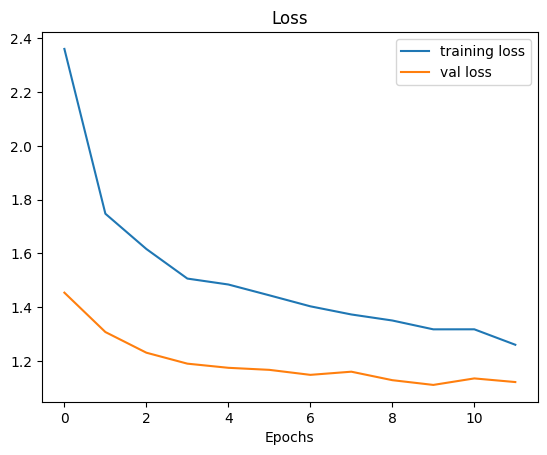

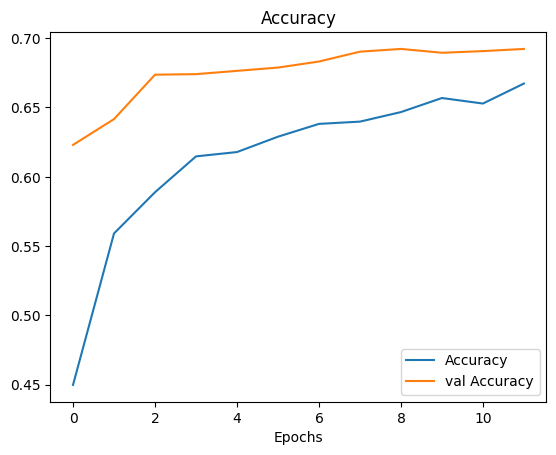

In [ ]:
plot_loss_curves(history_7)

1/1 [==============================] - 0s 29ms/step


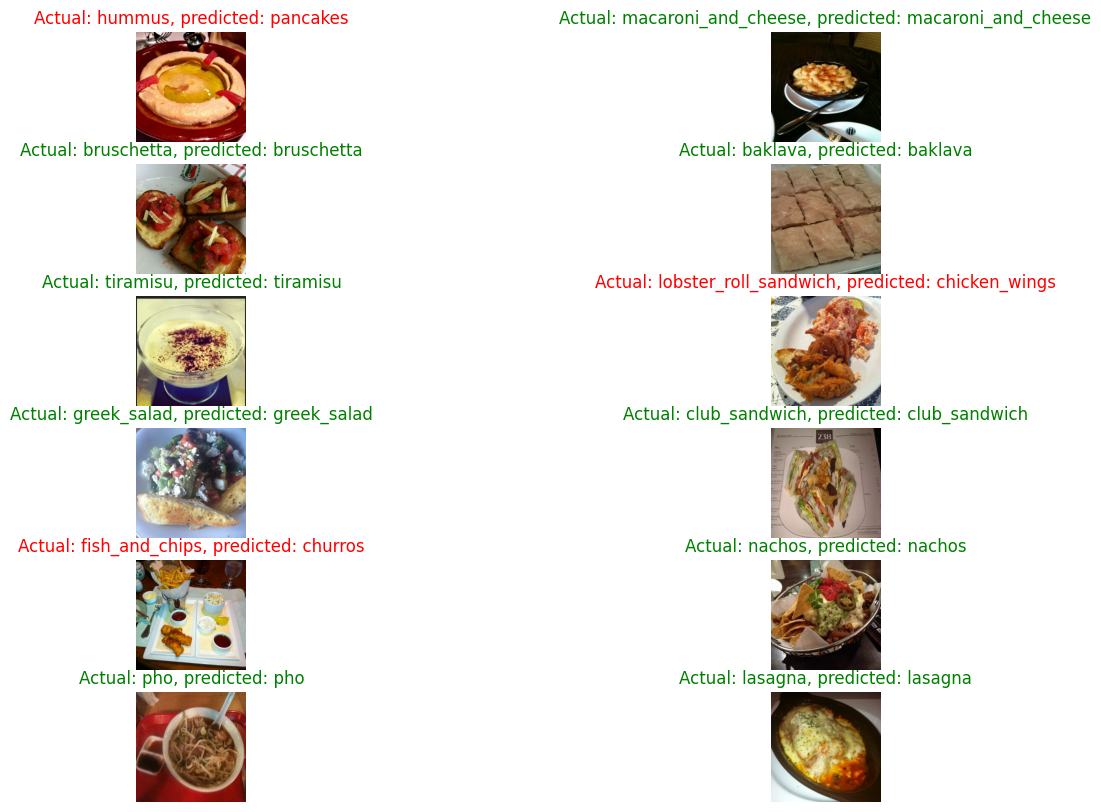

In [ ]:
test_visualize(dataset=train_data_50_percent, model_class=model_7, skip_num=2)


1/1 [==============================] - 0s 40ms/step


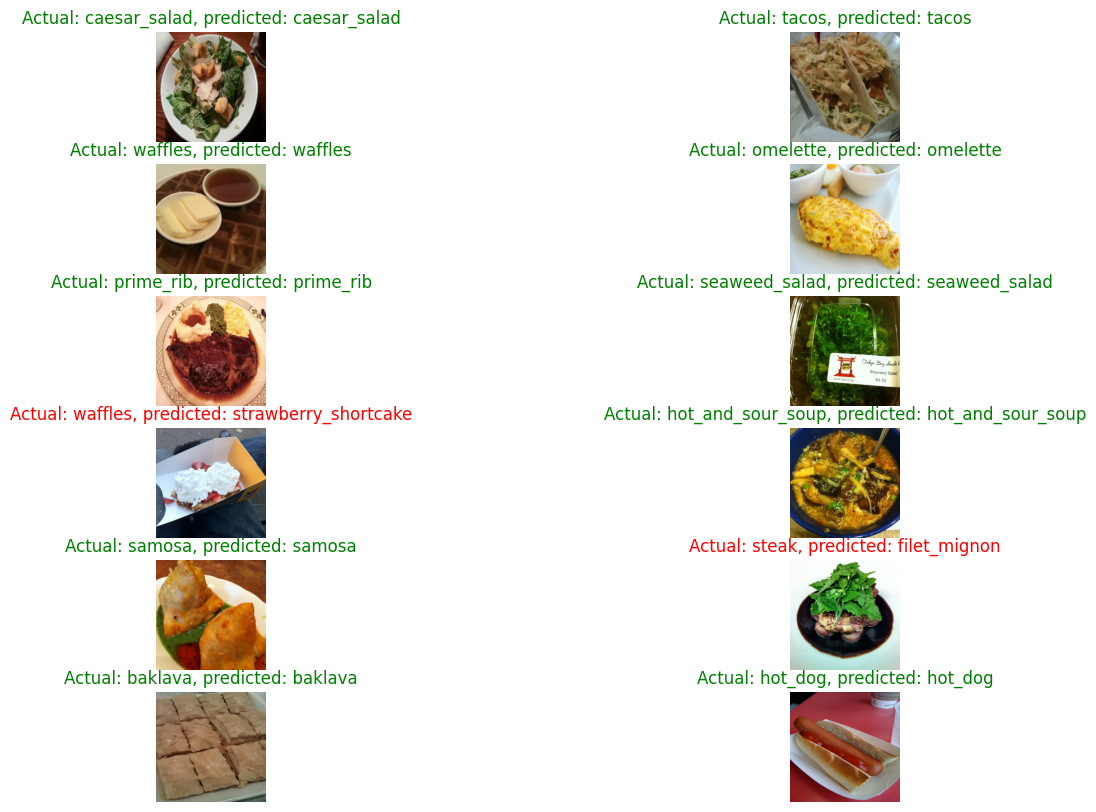

In [ ]:
test_visualize(dataset=train_data_50_percent, model_class=model_7)

# Training on the whole data with fine tuning

In [8]:
# creatign the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')
x = base_model(inputs, training=False)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) 

model_8 = tf.keras.Model(inputs, outputs)

model_8.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [9]:
# Compiling the Model
model_8.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## Feature Extractor model

In [14]:
initial_epoch = 5
history_8 = model_8.fit(train_data,
                    epochs=initial_epoch,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int( 0.25 * len(test_data)), # Only Validate on 25% of the test data
                    callbacks=[create_checkpoint_callback(monitor='val_accuracy'),] 
                    )

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7195 - accuracy: 0.5821
Epoch 1: val_accuracy improved from -inf to 0.69480, saving model to checkpoint/checkpoint.ckpt
2368/2368 [==============================] - 253s 99ms/step - loss: 1.7195 - accuracy: 0.5821 - val_loss: 1.1521 - val_accuracy: 0.6948
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.1992 - accuracy: 0.6891
Epoch 2: val_accuracy improved from 0.69480 to 0.72065, saving model to checkpoint/checkpoint.ckpt
2368/2368 [==============================] - 229s 95ms/step - loss: 1.1992 - accuracy: 0.6891 - val_loss: 1.0388 - val_accuracy: 0.7207
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0538 - accuracy: 0.7238
Epoch 3: val_accuracy improved from 0.72065 to 0.72478, saving model to checkpoint/checkpoint.ckpt
2368/2368 [==============================] - 231s 97ms/step - loss: 1.0538 - accuracy: 0.7238 - val_loss: 1.0025 - val_accuracy: 0.7248
Epoch 4

## Start Fine Tuning the Model

In [15]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

In [16]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [17]:
history_9 = model_8.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        initial_epoch=history_8.epoch[-1], # start from previous last epoch
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_early_stopping_callback()]
                        )

Epoch 5/100
2368/2368 [==============================] - 250s 100ms/step - loss: 0.7554 - accuracy: 0.7977 - val_loss: 0.9350 - val_accuracy: 0.7464
Epoch 6/100
2368/2368 [==============================] - 233s 98ms/step - loss: 0.6217 - accuracy: 0.8351 - val_loss: 0.9195 - val_accuracy: 0.7527
Epoch 7/100
2368/2368 [==============================] - 232s 97ms/step - loss: 0.5211 - accuracy: 0.8628 - val_loss: 0.9372 - val_accuracy: 0.7532
Epoch 8/100
2368/2368 [==============================] - 235s 98ms/step - loss: 0.4362 - accuracy: 0.8862 - val_loss: 0.9563 - val_accuracy: 0.7483
Epoch 9/100
2368/2368 [==============================] - 236s 99ms/step - loss: 0.3636 - accuracy: 0.9075 - val_loss: 0.9995 - val_accuracy: 0.7494
Epoch 10/100
2368/2368 [==============================] - 235s 98ms/step - loss: 0.2996 - accuracy: 0.9271 - val_loss: 1.0034 - val_accuracy: 0.7498


## Evaluation on the big model

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
model_8_evaluation = model_8.evaluate(test_data)

790/790 [==============================] - 87s 108ms/step - loss: 1.0099 - accuracy: 0.7484


In [27]:
tf.saved_model.save(model_8, "/content/drive/MyDrive/food_model_3")

1/1 [==============================] - 0s 31ms/step


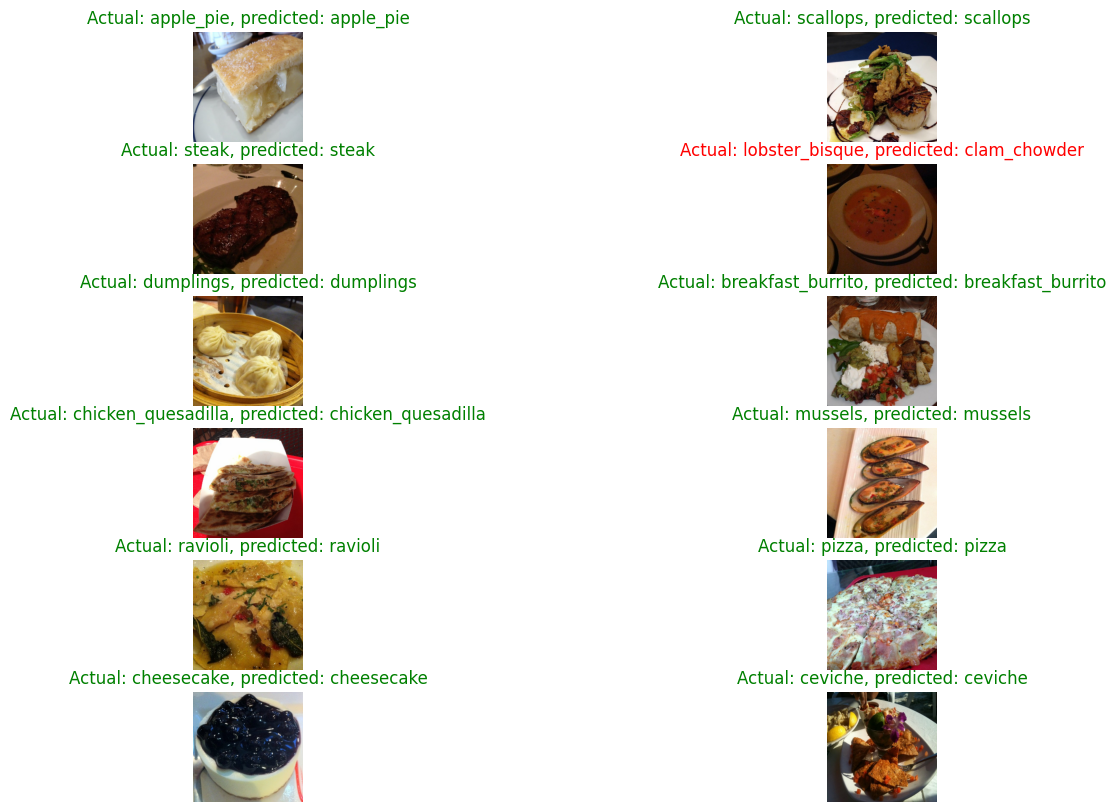

In [ ]:
test_visualize(model_class=model_8, dataset=test_data)

1/1 [==============================] - 0s 28ms/step


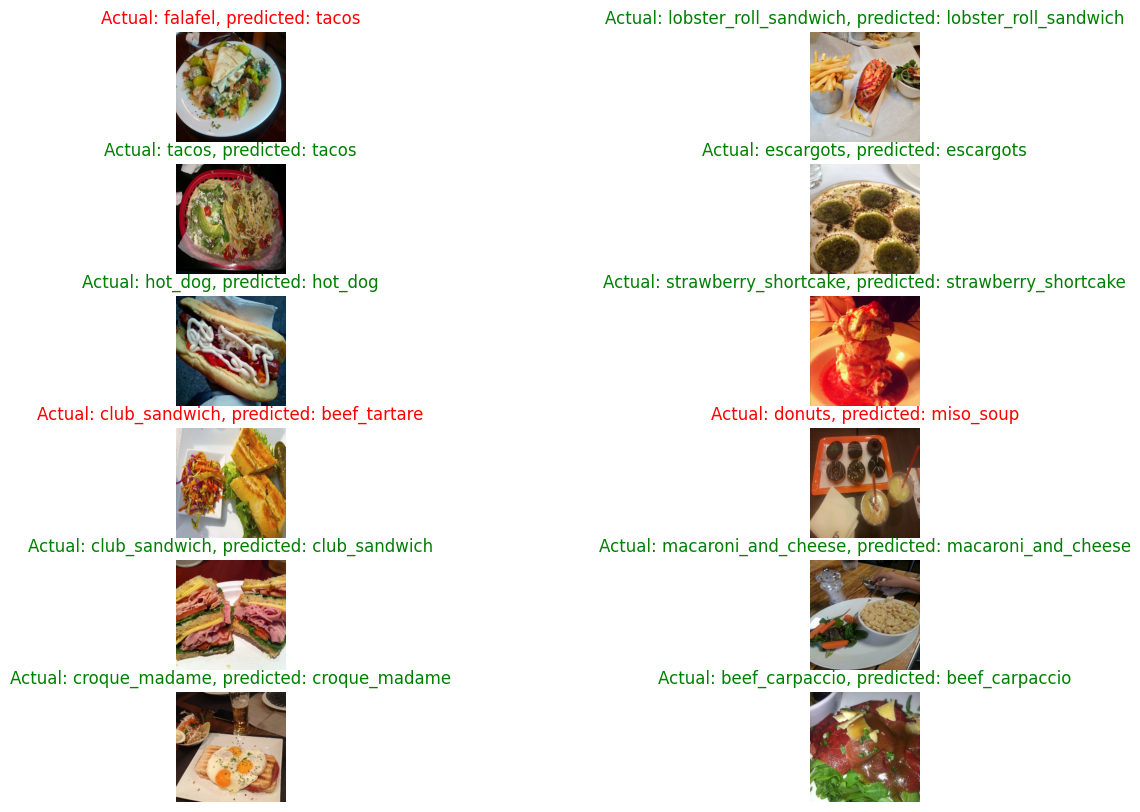

In [ ]:
test_visualize(model_class=model_8, dataset=test_data, skip_num=2)

# Adding DroupOut Layer to Reduce the Overfitting

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.2)(x) # used to reduce the overfitting
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
x = tf.keras.layers.Dense(64, activation='relu')(x) # addind for experiments
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) 

model_10 = tf.keras.Model(inputs, outputs)

model_10.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fitting the model
history_10 = model_10.fit(train_data,
          epochs=10,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.25 * len(test_data)),
          callbacks=[create_early_stopping_callback()])

Epoch 1/10
2368/2368 [==============================] - 245s 99ms/step - loss: 1.9003 - accuracy: 0.5257 - val_loss: 1.2571 - val_accuracy: 0.6558
Epoch 2/10
2368/2368 [==============================] - 232s 97ms/step - loss: 1.3596 - accuracy: 0.6432 - val_loss: 1.1368 - val_accuracy: 0.6873
Epoch 3/10
2368/2368 [==============================] - 231s 96ms/step - loss: 1.2249 - accuracy: 0.6744 - val_loss: 1.0921 - val_accuracy: 0.6983
Epoch 4/10
2368/2368 [==============================] - 229s 95ms/step - loss: 1.1397 - accuracy: 0.6948 - val_loss: 1.0847 - val_accuracy: 0.7021
Epoch 5/10
2368/2368 [==============================] - 233s 97ms/step - loss: 1.0768 - accuracy: 0.7087 - val_loss: 1.0805 - val_accuracy: 0.7051
Epoch 6/10
2368/2368 [==============================] - 263s 110ms/step - loss: 1.0310 - accuracy: 0.7193 - val_loss: 1.0839 - val_accuracy: 0.7019
Epoch 7/10
2368/2368 [==============================] - 239s 100ms/step - loss: 0.9910 - accuracy: 0.7289 - val_loss:

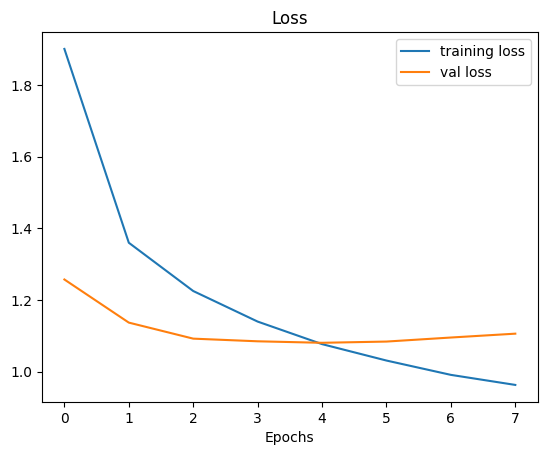

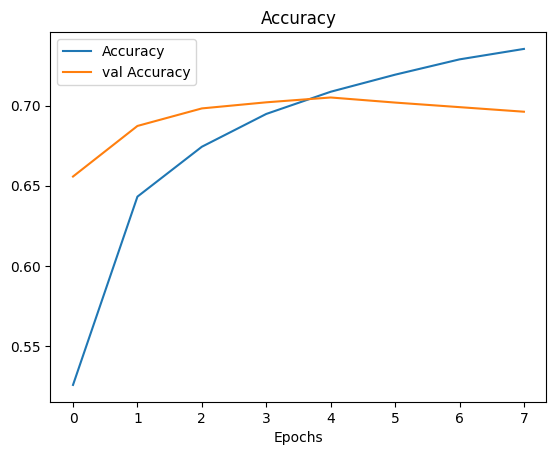

In [ ]:
plot_loss_curves(history_10)

## Fine Tuning the last model

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

model_10.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
history_10_fine_tuning = model_10.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        initial_epoch=history_10.epoch[-1], # start from previous last epoch
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_early_stopping_callback()]
                        )

Epoch 8/100
2368/2368 [==============================] - 243s 97ms/step - loss: 0.8482 - accuracy: 0.7663 - val_loss: 1.0069 - val_accuracy: 0.7286
Epoch 9/100
2368/2368 [==============================] - 248s 103ms/step - loss: 0.7096 - accuracy: 0.8037 - val_loss: 1.0041 - val_accuracy: 0.7292
Epoch 10/100
2368/2368 [==============================] - 247s 103ms/step - loss: 0.6121 - accuracy: 0.8303 - val_loss: 1.0129 - val_accuracy: 0.7327
Epoch 11/100
2368/2368 [==============================] - 245s 102ms/step - loss: 0.5296 - accuracy: 0.8516 - val_loss: 1.0234 - val_accuracy: 0.7329
Epoch 12/100
2368/2368 [==============================] - 237s 99ms/step - loss: 0.4583 - accuracy: 0.8722 - val_loss: 1.0412 - val_accuracy: 0.7321
Epoch 13/100
2368/2368 [==============================] - 239s 100ms/step - loss: 0.3925 - accuracy: 0.8903 - val_loss: 1.0623 - val_accuracy: 0.7316
Epoch 14/100
2368/2368 [==============================] - 236s 98ms/step - loss: 0.3373 - accuracy: 0.90

In [ ]:
model_10.evaluate(test_data)

790/790 [==============================] - 78s 96ms/step - loss: 1.2022 - accuracy: 0.7282


[1.2022238969802856, 0.7282376289367676]

# Data Augmentation with the whole Data and Fine Tuning

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

# creating the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# set the transfer learning model as a feature extractor
base_model.trainable = False

# Define the inputs layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='Input_layer')

x = data_augmentation(inputs)

# initialize the base model and connect it to the inputs layer
x = base_model(x, training=False)

# To Take the important features from the image
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# the output layer
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) 

model_11 = tf.keras.Model(inputs, outputs)

model_11.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_11 = model_11.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int( 0.25 * len(test_data)),
                    callbacks=[create_early_stopping_callback()] 
                    )

Epoch 1/5
2368/2368 [==============================] - 571s 230ms/step - loss: 2.0870 - accuracy: 0.4966 - val_loss: 1.2920 - val_accuracy: 0.6553
Epoch 2/5
2368/2368 [==============================] - 345s 145ms/step - loss: 1.5977 - accuracy: 0.5929 - val_loss: 1.2018 - val_accuracy: 0.6699
Epoch 3/5
2368/2368 [==============================] - 295s 123ms/step - loss: 1.4697 - accuracy: 0.6213 - val_loss: 1.1599 - val_accuracy: 0.6869
Epoch 4/5
2368/2368 [==============================] - 280s 117ms/step - loss: 1.4016 - accuracy: 0.6366 - val_loss: 1.1343 - val_accuracy: 0.6913
Epoch 5/5
2368/2368 [==============================] - 276s 116ms/step - loss: 1.3479 - accuracy: 0.6491 - val_loss: 1.1291 - val_accuracy: 0.6891


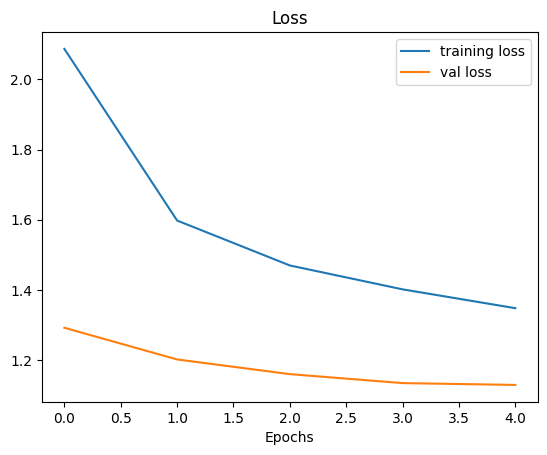

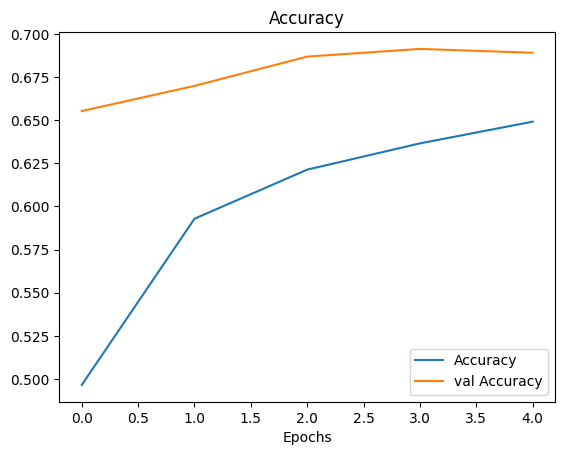

In [ ]:
plot_loss_curves(history_11)

## Start Fine Tuning for the Augumented Model

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

model_11.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
history_11_fine_tuning = model_11.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        initial_epoch=history_11.epoch[-1], # start from previous last epoch
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_early_stopping_callback()]
                        )

Epoch 5/100
2368/2368 [==============================] - 294s 118ms/step - loss: 1.2171 - accuracy: 0.6790 - val_loss: 1.0559 - val_accuracy: 0.7175
Epoch 6/100
2368/2368 [==============================] - 271s 113ms/step - loss: 1.1131 - accuracy: 0.7025 - val_loss: 1.0152 - val_accuracy: 0.7211
Epoch 7/100
2368/2368 [==============================] - 271s 113ms/step - loss: 1.0373 - accuracy: 0.7210 - val_loss: 1.0016 - val_accuracy: 0.7232
Epoch 8/100
2368/2368 [==============================] - 266s 111ms/step - loss: 0.9802 - accuracy: 0.7346 - val_loss: 0.9973 - val_accuracy: 0.7292
Epoch 9/100
2135/2368 [==========================>...] - ETA: 24s - loss: 0.9326 - accuracy: 0.7452